In [1]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cellnet

[notice] A new release of pip is available: 23.1.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!pip install -q SPARQLWrapper

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cellnet 0.1.0 requires merlin-core>=23.2, but you have merlin-core 0+untagged.1.gdf03015 which is incompatible.
cellnet 0.1.0 requires merlin-dataloader>=23.2, but you have merlin-dataloader 0+untagged.1.gbcd6dcf which is incompatible.
cellnet 0.1.0 requires pandas>=1.5, but you have pandas 1.3.5 which is incompatible.
cellnet 0.1.0 requires pyarrow>=10.0.0, but you have pyarrow 8.0.0 which is incompatible.
cellnet 0.1.0 requires setuptools>=62.1.0, but you have setuptools 45.2.0 which is incompatible.

[notice] A new release of pip is available: 23.1.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
%load_ext autoreload

In [2]:
import pickle
import os
from os.path import join


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [3]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

## Pre-calculate predictions

### Tabnet

In [4]:
from predictions import eval_tabnet

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [5]:
CKPT_PATH_TABNET = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default/w_augment_4/checkpoints/val_f1_macro_epoch=45_val_f1_macro=0.847.ckpt'

In [6]:
if not os.path.isfile('model_eval_cache/preds_tabnet.pkl'):
    preds_tabnet = eval_tabnet([CKPT_PATH_TABNET], DATA_PATH)[0]
    # save predictions to disk
    with open('model_eval_cache/preds_tabnet.pkl', 'wb') as f:
        pickle.dump(preds_tabnet, f)
else:
    # load cached predictions
    with open('model_eval_cache/preds_tabnet.pkl', 'rb') as f:
        preds_tabnet = pickle.load(f)


### Optimized Linear

In [7]:
from predictions import eval_linear

In [8]:
CKPT_PATH_LINEAR = '/mnt/dssfs02/tb_logs/juwles/cxg_2023_05_15_linear/default/version_1/checkpoints/val_f1_macro_epoch=33_val_f1_macro=0.773.ckpt'

In [9]:
if not os.path.isfile('model_eval_cache/preds_linear.pkl'):
    preds_linear = eval_linear([CKPT_PATH_LINEAR], DATA_PATH)[0]
    # save predictions to disk
    with open('model_eval_cache/preds_linear.pkl', 'wb') as f:
        pickle.dump(preds_linear, f)
else:
    # load cached predictions
    with open('model_eval_cache/preds_linear.pkl', 'rb') as f:
        preds_linear = pickle.load(f)


### CellTypist

In [10]:
!pip install -q celltypist==1.5.3


[notice] A new release of pip is available: 23.1.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [10]:
from predictions import eval_celltypist

In [11]:
CKPT_PATH_CELLTYPIST = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_celltypist/model_1500000_cells_run1.pkl'

In [12]:
if not os.path.isfile('model_eval_cache/preds_celltypist.pkl'):
    preds_celltypist = eval_celltypist([CKPT_PATH_CELLTYPIST], DATA_PATH)[0]
    # save predictions to disk
    with open('model_eval_cache/preds_celltypist.pkl', 'wb') as f:
        pickle.dump(preds_celltypist, f)
else:
    # load cached predictions
    with open('model_eval_cache/preds_celltypist.pkl', 'rb') as f:
        preds_celltypist = pickle.load(f)


## Tabnet vs Linear (Reviewer #1 - comment 1)

In [13]:
from utils import correct_labels
from sklearn.metrics import classification_report

In [14]:
import yaml

with open('shortend_cell_types.yaml', 'r') as f:
    shortend_cell_types = yaml.safe_load(f)

In [15]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
inverse_cell_type_mapping = {v: k for k, v in cell_type_mapping.label.to_dict().items()}
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()

# hierachy correct predictions
preds_tabnet = correct_labels(y_true, preds_tabnet, cell_type_hierarchy)
preds_linear = correct_labels(y_true, preds_linear, cell_type_hierarchy)
preds_celltypist = correct_labels(y_true, preds_celltypist, cell_type_hierarchy)

In [16]:
clf_reports = []

for model, preds in [('scTab', preds_tabnet), ('Optimized Linear', preds_linear), ('CellTypist', preds_celltypist)]:
    clf_reports.append(
        pd.DataFrame(classification_report(y_true, preds, output_dict=True)).T.iloc[:-3]
        .assign(model=model)
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict()),
            cell_type_short=lambda df: df.cell_type.replace(shortend_cell_types)
        )
    )

clf_report = pd.concat(clf_reports)

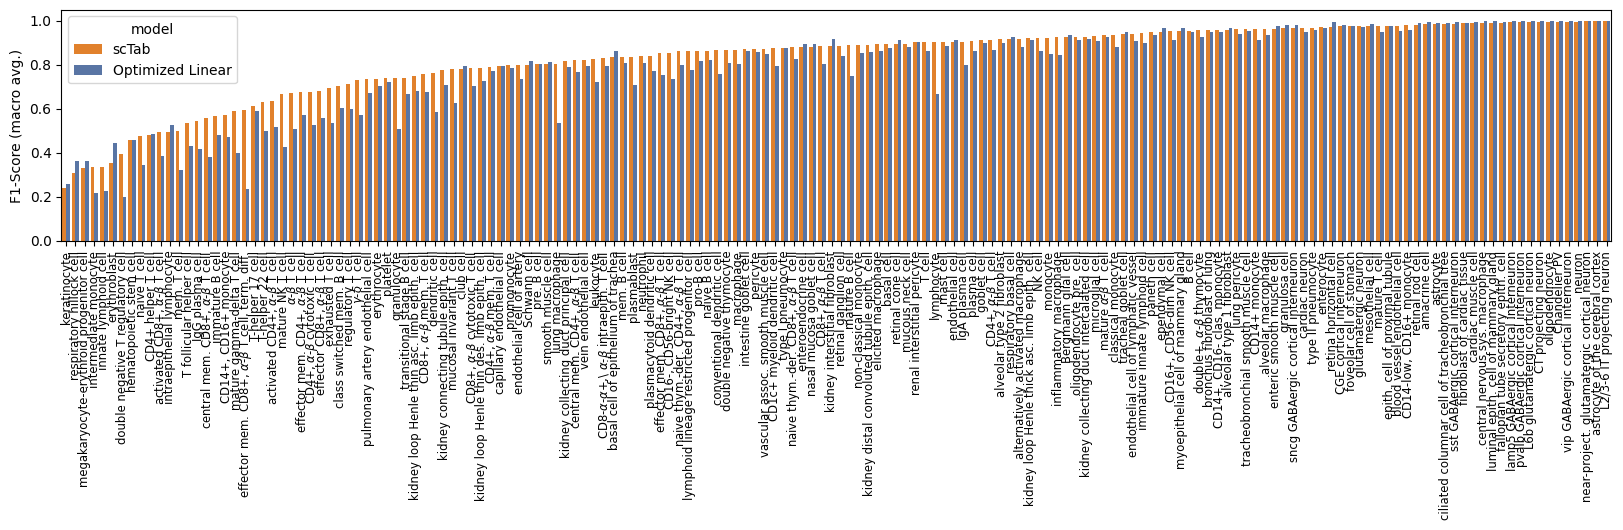

In [17]:
plt.rcParams['figure.figsize'] = (20, 3)

ax = sns.barplot(
    data=clf_report.query('model in ["scTab", "Optimized Linear"]'),
    x='cell_type_short',
    y='f1-score',
    hue='model',
    palette=['#ff7f0e', '#4C72B0'],
    order=clf_report.query('`model` == "scTab"').sort_values('f1-score').cell_type_short
)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
ax.set_ylabel('F1-Score (macro avg.)')
ax.xaxis.set_tick_params(labelsize='small');

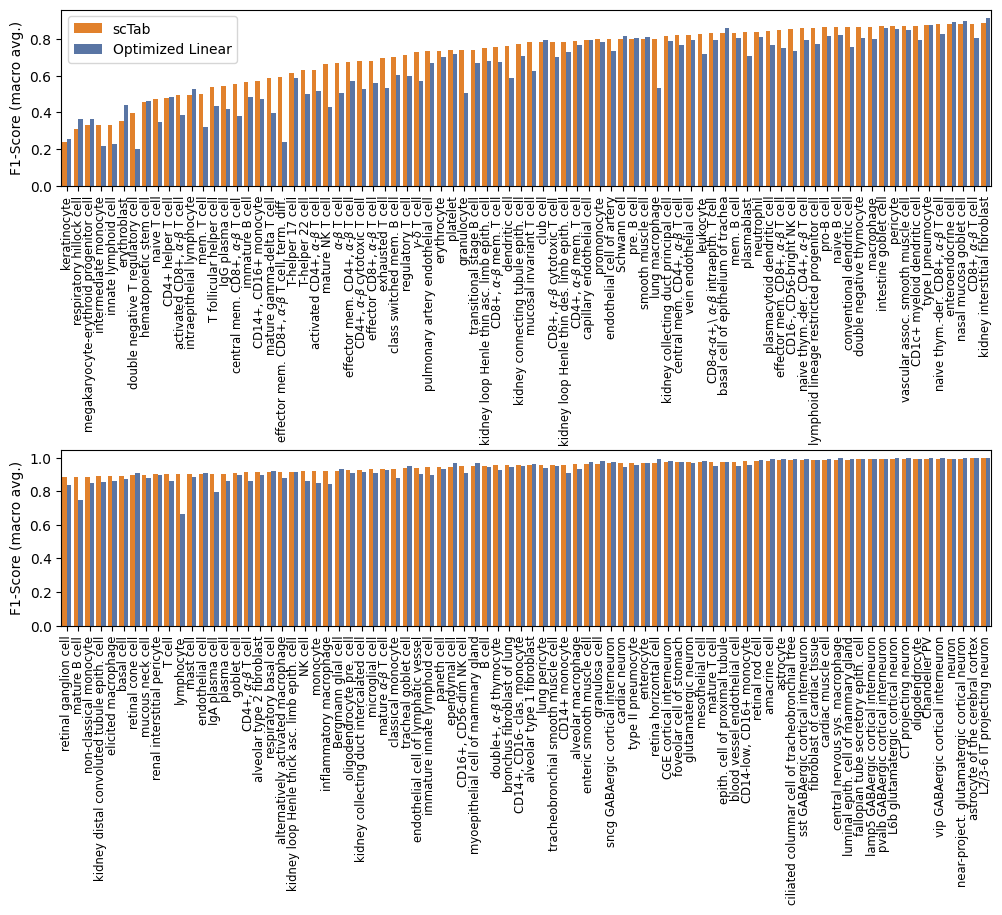

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

celltypes1, celltypes2 = np.array_split(clf_report.query('`model` == "scTab"').sort_values('f1-score').cell_type_short.to_numpy(), 2)
sns.barplot(
    data=clf_report.query('model in ["scTab", "Optimized Linear"]'),
    x='cell_type_short',
    y='f1-score',
    hue='model',
    palette=['#ff7f0e', '#4C72B0'],
    order=celltypes1,
    ax=axs[0]
)
sns.barplot(
    data=clf_report.query('model in ["scTab", "Optimized Linear"]'),
    x='cell_type_short',
    y='f1-score',
    hue='model',
    palette=['#ff7f0e', '#4C72B0'],
    order=celltypes2,
    ax=axs[1]
)
plt.subplots_adjust(hspace=1.5)

for ax in axs:
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('F1-Score (macro avg.)')
    ax.xaxis.set_tick_params(labelsize='small')
    ax.legend(title='')

axs[1].get_legend().set_visible(False)

In [19]:
clf_report_tabnet = clf_report.query('model == "scTab"').copy()

clf_report_tabnet['f1_difference'] = (
    clf_report.query('model == "scTab"')['f1-score'] - clf_report.query('model == "Optimized Linear"')['f1-score']
)

In [20]:
from IPython.display import display

with pd.option_context('display.max_colwidth', None):
    df = (
        clf_report_tabnet
        .sort_values('f1_difference', ascending=False)
        .head(25)
        [['cell_type_short', 'f1_difference']]
        # .assign(f1_difference=lambda xx: xx.f1_difference.apply("{0:.3f}".format))
    )
    display(df)


,cell_type_short,f1_difference
61,"effector mem. CD8+, $\alpha$-$\beta$ T cell, term. diff.",0.356455
102,lung macrophage,0.267934
109,mature NK T cell,0.238586
104,lymphocyte,0.237672
80,granulocyte,0.231730
55,double negative T regulatory cell,0.193232
112,mature gamma-delta T cell,0.190337
115,mem. T cell,0.178274
54,dendritic cell,0.176498
45,"central mem. CD8+, $\alpha$-$\beta$ T cell",0.174661


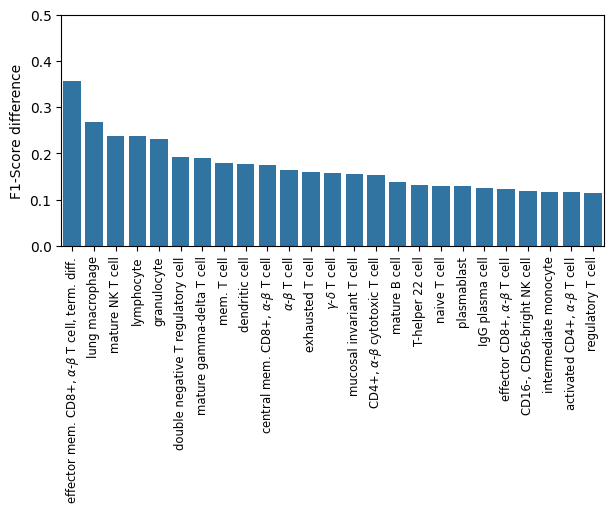

In [21]:
plt.rcParams['figure.figsize'] = (7, 3)

plot_df = clf_report.query(f'model in ["scTab", "Optimized Linear"] and cell_type_short in {df.cell_type_short.tolist()}')
ax = sns.barplot(
    data=df,
    x='cell_type_short',
    y='f1_difference',
    color='#1f77b4'
)
ax.set_ylim(0., 0.5)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
ax.set_ylabel('F1-Score difference')
ax.xaxis.set_tick_params(labelsize='small');

In [22]:
# The cells with biggest difference are in f1-scores are often T cells
# look into what the linear reference models predict for this

In [23]:
from cellnet.utils.cell_ontology import retrieve_child_nodes_from_ubergraph

t_cell_subtypes = [
    elem for elem in retrieve_child_nodes_from_ubergraph(['T cell'])['T cell']
    if elem in cell_type_mapping.label.tolist()
]
t_cell_subtypes_int = [
    inverse_cell_type_mapping[elem] for elem in t_cell_subtypes
]

len(t_cell_subtypes) / len(cell_type_mapping)

0.22560975609756098

In [24]:
clf_report_tabnet.loc[clf_report_tabnet.cell_type.isin(t_cell_subtypes)].f1_difference.mean()

0.10308303613355477

In [25]:
cell_types_with_big_performance_difference = (
    clf_report_tabnet
    .sort_values('f1_difference', ascending=False)
    .head(25)
    .cell_type.tolist()
)

t_cells = [elem for elem in cell_types_with_big_performance_difference if elem in t_cell_subtypes]

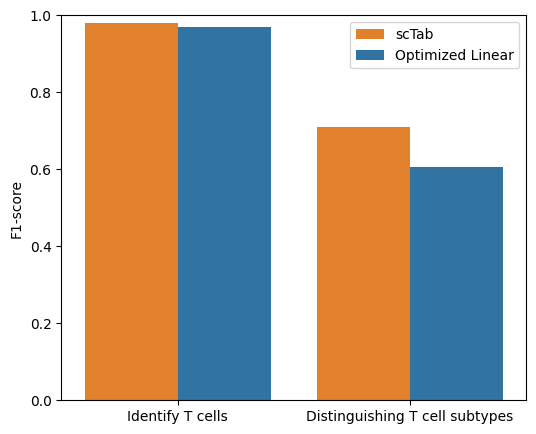

In [26]:
from sklearn.metrics import f1_score


df_plot = pd.DataFrame({
    'F1-score': [
        f1_score(np.isin(y_true, t_cell_subtypes_int), np.isin(preds_tabnet, t_cell_subtypes_int)),
        f1_score(np.isin(y_true, t_cell_subtypes_int), np.isin(preds_linear, t_cell_subtypes_int)),
        clf_report.query(f'model == "scTab" and cell_type in {t_cell_subtypes}')['f1-score'].mean(),
        clf_report.query(f'model == "Optimized Linear" and cell_type in {t_cell_subtypes}')['f1-score'].mean()
    ],
    'label_granularity': np.repeat(['Identify T cells', 'Distinguishing T cell subtypes'], 2),
    'model': ['scTab', 'Optimized Linear', 'scTab', 'Optimized Linear']
})


fig, ax = plt.subplots(1, 1, figsize=[6, 5], sharey=True)
sns.barplot(
    data=df_plot, 
    x='label_granularity', 
    y='F1-score', 
    hue='model', 
    palette=['#ff7f0e', '#1f77b4'],
    ax=ax
)
ax.set_ylim(0., 1.)
ax.legend(title='')
ax.set_xlabel('');

In [27]:
df_plot

,F1-score,label_granularity,model
0,0.979949,Identify T cells,scTab
1,0.969356,Identify T cells,Optimized Linear
2,0.709552,Distinguishing T cell subtypes,scTab
3,0.606469,Distinguishing T cell subtypes,Optimized Linear


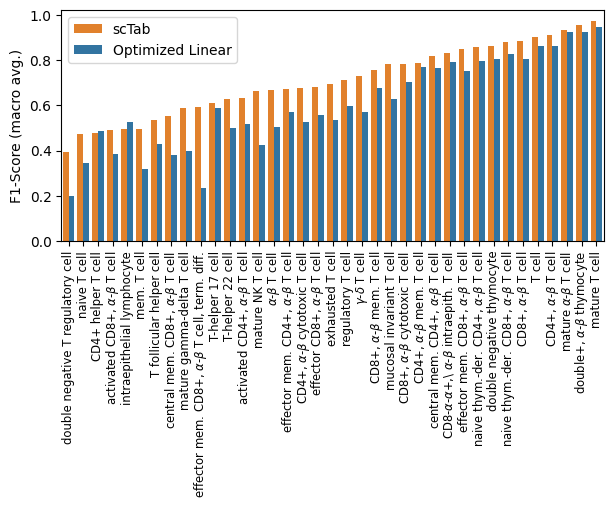

In [27]:
plt.rcParams['figure.figsize'] = (7, 3)

ax = sns.barplot(
    data=clf_report.query(f'model in ["scTab", "Optimized Linear"] and cell_type in {t_cell_subtypes}'),
    x='cell_type_short',
    y='f1-score',
    hue='model',
    palette=['#ff7f0e', '#1f77b4'],
    order=clf_report.query(f'`model` == "scTab" and cell_type in {t_cell_subtypes}').sort_values('f1-score').cell_type_short
)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
ax.legend(title='')
ax.set_ylabel('F1-Score (macro avg.)')
ax.xaxis.set_tick_params(labelsize='small');

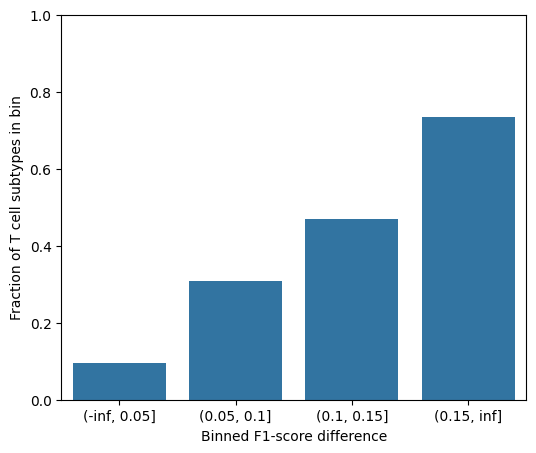

In [28]:
df_plot = (
    clf_report_tabnet[['cell_type']]
    .groupby(pd.cut(clf_report_tabnet['f1_difference'], [-np.inf, 0.05, 0.1, 0.15, np.inf]))
    .agg(list)['cell_type']
    .apply(lambda x: len([elem for elem in x if elem in t_cell_subtypes]) / len(x))
    .to_frame().reset_index()
)

fig, ax = plt.subplots(1, 1, figsize=[6, 5], sharey=True)
sns.barplot(data=df_plot, x='f1_difference', y='cell_type', ax=ax, color='#1f77b4')
ax.set_xlabel('Binned F1-score difference')
ax.set_ylabel('Fraction of T cell subtypes in bin')
ax.set_ylim(0., 1.);

## Easy to predict cell types despite only limited training data (Reviewer #1 - comment 3)

In [4]:
# TODO: Look at TabNet attention masks and see if those cell types have any very distinct features

In [81]:
import dask.dataframe as dd
import dask.array as da

from scipy.sparse import csr_matrix

In [82]:
%autoreload
from cellnet.utils.tabnet_explain import explain
from cellnet.utils.data_loading import dataloader_factory

In [83]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
inverse_cell_type_mapping = {v: k for k, v in cell_type_mapping.label.to_dict().items()}

In [8]:
# list of easy to predict cell types (already based on a small amount of training data)

easy_cell_types = [
    'Bergmann glial cell',
    'L6b glutamatergic cortical neuron',
    'alternatively activated macrophage',
    'bronchus fibroblast of lung',
    'cardiac neuron',
    'caudal ganglionic eminence derived GABAergic cortical interneuron',
    'chandelier pvalb GABAergic cortical interneuron',
    'ependymal cell',
    'inflammatory macrophage',
    'lung pericyte',
    'paneth cell',
    'renal interstitial pericyte',
    'retina horizontal cell'
]

hard_cell_types = [
    'double negative T regulatory cell',
    'erythroblast',
    'innate lymphoid cell',
    'intermediate monocyte',
    'megakaryocyte-erythroid progenitor cell',
    'respiratory hillock cell'
]

In [9]:
from cellnet.utils.cell_ontology import retrieve_child_nodes_from_ubergraph


neuron_subypes_overall = [
    elem for elem in retrieve_child_nodes_from_ubergraph(['neuron'])['neuron']
    if elem in cell_type_mapping.label.tolist()
]
neuron_subtypes_easy = [
    elem for elem in retrieve_child_nodes_from_ubergraph(['neuron'])['neuron']
    if elem in easy_cell_types
]


print(f"Overall fraction: {len(neuron_subypes_overall) / len(cell_type_mapping.label.tolist()):.3f}")
print(f"Easy to predict fraction: {len(neuron_subtypes_easy) / len(easy_cell_types):.3f}")

Overall fraction: 0.110
Easy to predict fraction: 0.385


In [10]:
def get_count_matrix_and_obs(ddf):
    obs = ddf[['cell_type', 'tech_sample', 'assay', 'dataset_id', 'tissue']].compute()
    x = (
        ddf['X']
        .map_partitions(
            lambda xx: pd.DataFrame(np.vstack(xx.tolist())), 
            meta={col: 'f4' for col in range(19331)}
        )
        .to_dask_array(lengths=[1024] * ddf.npartitions)
    )
    obs = ddf[['cell_type', 'tech_sample', 'assay', 'dataset_id', 'tissue']].compute().reset_index(drop=True)

    return x, obs


In [11]:
ddf_train = dd.read_parquet(join(DATA_PATH, 'train'), split_row_groups=True)
ddf_test = dd.read_parquet(join(DATA_PATH, 'test'), split_row_groups=True)

x_train, obs_train = get_count_matrix_and_obs(ddf_train)
x_test, obs_test = get_count_matrix_and_obs(ddf_test)

In [12]:
# subset x_train to save memory
x_train = x_train[:4_000_000, :]
obs_train = obs_train[:4_000_000]

In [13]:
from cellnet.models import TabnetClassifier
from cellnet.estimators import EstimatorCellTypeClassifier


idxs = obs_train[obs_train.cell_type.isin(
    [inverse_cell_type_mapping[elem] for elem in easy_cell_types + hard_cell_types]
)].index.to_numpy()
obs_ = obs_train.iloc[idxs].copy()
obs_['cell_type'] = pd.Categorical(
    obs_.cell_type.replace(cell_type_mapping.label.to_dict()), 
    cell_type_mapping.label.tolist(), 
    ordered=False
)


if not os.path.isfile('model_eval_cache/explain.pkl'):
    x_ = x_train[idxs, :].map_blocks(csr_matrix).compute()

    CKPT_PATH_TABNET = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default/w_augment_4/checkpoints/val_f1_macro_epoch=45_val_f1_macro=0.847.ckpt'
    estim = EstimatorCellTypeClassifier(DATA_PATH)
    estim.init_datamodule(batch_size=2048)
    model = TabnetClassifier.load_from_checkpoint(CKPT_PATH_TABNET, **estim.get_fixed_model_params('tabnet'))
    loader = dataloader_factory(x_, obs_)
    explain_masks = explain(model, loader, only_return_nnz_idxs=False, normalize=True)
    with open('model_eval_cache/explain.pkl', 'wb') as f:
        pickle.dump(explain_masks, f)
else:
    # load cached predictions
    with open('model_eval_cache/explain.pkl', 'rb') as f:
        explain_masks = pickle.load(f)


/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [14]:
(explain_masks != 0.).mean()

0.012234843245702298

In [15]:
explain_masks.shape

(27861, 19331)

In [16]:
x_ = x_train[idxs, :].map_blocks(csr_matrix).compute()

In [17]:
input_features = x_.toarray() * explain_masks

In [18]:
(input_features != 0.).mean()

0.002425750299085472

In [19]:
(input_features.mean(axis=0) >= 1e-4).mean()

0.0121049092131809

In [33]:
top_x_genes = {}

for cell_type in easy_cell_types + hard_cell_types:
    top_x_genes[cell_type] = np.argsort(
        -input_features[(obs_.cell_type == cell_type).to_numpy(), :].mean(axis=0)
    )[:200]

genes = []
for gene_idxs in top_x_genes.values():
    genes += gene_idxs.tolist()
genes = list(set(genes))

len(genes)

608

In [34]:
# get all the genes in one go and subset later
x_fit_train = x_train[:, genes].compute()
x_fit_train = {gene_idx: x_fit_train[:, i] for i, gene_idx in enumerate(genes)}

x_fit_test = x_test[:, genes].compute()
x_fit_test = {gene_idx: x_fit_test[:, i] for i, gene_idx in enumerate(genes)}

In [35]:
cell_types_to_check = [
    # easy cell types
    ('Bergmann glial cell', 'easy'),
    ('L6b glutamatergic cortical neuron', 'easy'),
    ('alternatively activated macrophage', 'easy'),
    ('bronchus fibroblast of lung', 'easy'),
    ('cardiac neuron', 'easy'),
    ('caudal ganglionic eminence derived GABAergic cortical interneuron', 'easy'),
    ('chandelier pvalb GABAergic cortical interneuron', 'easy'),
    ('ependymal cell', 'easy'),
    ('inflammatory macrophage', 'easy'), 
    ('lung pericyte', 'easy'),
    ('paneth cell', 'easy'),
    ('renal interstitial pericyte', 'easy'),
    ('retina horizontal cell', 'easy'),
    # hard cell types
    ('double negative T regulatory cell', 'hard'),
    ('erythroblast', 'hard'),
    ('innate lymphoid cell', 'hard'),
    ('intermediate monocyte', 'hard'),
    ('megakaryocyte-erythroid progenitor cell', 'hard'),
    ('respiratory hillock cell', 'hard'),
]

In [36]:
from sklearn.metrics import precision_recall_curve, auc


def select_cells(obs, celltype, subsample=100_000, seed=1):
    rng = np.random.default_rng(seed)
    idxs_positive = np.where((obs.cell_type == celltype).to_numpy())[0]
    idxs_negative = rng.choice(
        np.where((obs.cell_type != celltype).to_numpy())[0],
        size=subsample, replace=False
    )
    cell_ind = np.zeros(len(obs), dtype=bool)
    cell_ind[idxs_positive] = True
    cell_ind[idxs_negative] = True
 
    return cell_ind


def auc_pr(clf, x, y):
    y_scores = clf.predict_proba(x)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_scores)
    return auc(recall, precision)
    

In [37]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score, roc_auc_score
from tqdm import tqdm

from cellnet.utils.cell_ontology import retrieve_child_nodes_from_ubergraph


cell_types = []
scores_train = []
scores_test = []
grouping = []


for fine, group in tqdm(cell_types_to_check):
    fine_int = inverse_cell_type_mapping[fine]
    top_genes = top_x_genes[fine]
    x_subtype_train = np.concatenate([x_fit_train[idx].reshape((-1, 1)) for idx  in top_genes], axis=1)
    x_subtype_test = np.concatenate([x_fit_test[idx].reshape((-1, 1)) for idx  in top_genes], axis=1)
    cell_ind_train = select_cells(obs_train, fine_int)
    cell_ind_test = select_cells(obs_test, fine_int)
    # subset data
    x_subtype_train = x_subtype_train[cell_ind_train, :]
    y_train = (obs_train.cell_type == fine_int).to_numpy()[cell_ind_train]
    x_subtype_test = x_subtype_test[cell_ind_test, :]
    y_test = (obs_test.cell_type == fine_int).to_numpy()[cell_ind_test]

    cell_types.append(fine)
    grouping.append(group)
    clf = LogisticRegression(
        class_weight='balanced', 
        penalty='l2',
        max_iter=10000, 
        solver='newton-cholesky'
    ).fit(x_subtype_train, y_train)
    scores_test.append(auc_pr(clf, x_subtype_test, y_test))
    scores_train.append(auc_pr(clf, x_subtype_train, y_train))


df = pd.DataFrame({
    'cell_type': cell_types,
    'scores_train': scores_train,
    'scores_test': scores_test,
    'grouping': grouping
})
df #.sort_values('roc_auc_scores', ascending=False)

100%|██████████| 19/19 [11:14<00:00, 35.50s/it]


,cell_type,scores_train,scores_test,grouping
0,Bergmann glial cell,0.997536,0.973046,easy
1,L6b glutamatergic cortical neuron,0.995522,0.983456,easy
2,alternatively activated macrophage,0.895220,0.852370,easy
3,bronchus fibroblast of lung,0.902412,0.938862,easy
4,cardiac neuron,0.993543,0.970826,easy
5,caudal ganglionic eminence derived GABAergic c...,0.985378,0.956747,easy
6,chandelier pvalb GABAergic cortical interneuron,0.999644,0.992326,easy
7,ependymal cell,0.999937,0.993460,easy
8,inflammatory macrophage,0.832940,0.727149,easy
9,lung pericyte,0.934170,0.915892,easy


In [39]:
mean_easy_test = df.query('grouping == "easy"').scores_test.mean()
mean_easy_train = df.query('grouping == "easy"').scores_train.mean()
mean_hard_test = df.query('grouping == "hard"').scores_test.mean()
mean_hard_train = df.query('grouping == "hard"').scores_train.mean()

In [40]:
mean_easy_train - mean_easy_test

0.025815322433014654

In [41]:
mean_hard_train - mean_hard_test

0.3181350792513161

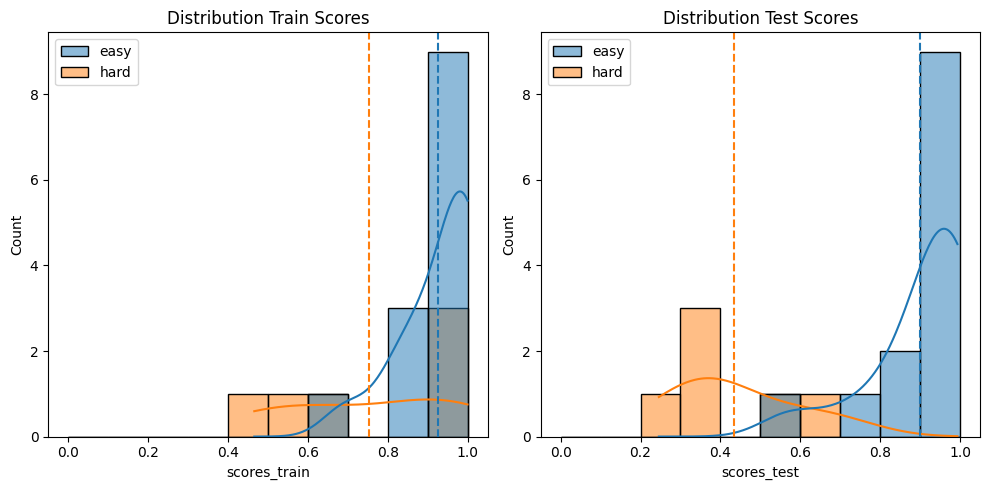

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(
    df, x='scores_train', hue='grouping', ax=axs[0], 
    kde=True, binrange=[0., 1.], hue_order=['easy', 'hard'], binwidth=0.1
)
axs[0].set_title('Distribution Train Scores')
axs[0].axvline(mean_easy_train, color='#1f77b4', linestyle='--')
axs[0].axvline(mean_hard_train, color='#ff7f0e', linestyle='--')
sns.histplot(
    df, x='scores_test', hue='grouping', ax=axs[1], 
    kde=True, binrange=[0., 1.], hue_order=['easy', 'hard'], binwidth=0.1
)
axs[1].set_title('Distribution Test Scores')
axs[1].axvline(mean_easy_test, color='#1f77b4', linestyle='--')
axs[1].axvline(mean_hard_test, color='#ff7f0e', linestyle='--')

for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend_.set_title(None)

plt.tight_layout()
plt.show()

In [45]:
var = pd.read_parquet(join(DATA_PATH, 'var.parquet'))

top_x_genes_specific = {
    celltype: var.loc[genes[:25].astype(str)].feature_name.tolist()
    for celltype, genes in top_x_genes.items()
}

index = []
data = []
celltype_grouping = dict(cell_types_to_check)
for k, v in top_x_genes_specific.items():
    if celltype_grouping[k] == 'easy':
        index.append(k)
        data.append(v)
        gene_names = v

top_marker_genes = pd.DataFrame(data, index)
top_marker_genes.to_csv('markers.csv')
top_marker_genes.loc[:, range(15)] #.to_csv('markers.csv')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Bergmann glial cell,PTPRZ1,RGL1,KCNN2,SCRG1,FASTKD2,CSMD1,KLHL32,GPM6B,LCORL,ADGRL3,PCYT2,TERF2IP,SLC44A1,SUMF1,GABRB3
L6b glutamatergic cortical neuron,WDFY3,SH3GL2,CDH12,WRNIP1,GNAQ,CSMD1,SYT1,KCTD16,NRXN1,IGSF21,TANC2,EPHB1,RPL6,NTM,THY1
alternatively activated macrophage,RPL8,RAB31,NDUFA1,FGFR1,FCGR3A,SDCBP,B2M,GNAQ,PCMT1,WRNIP1,UBE2L3,ATP1B3,S100A4,RPL35A,ATXN1
bronchus fibroblast of lung,PTGES3,DGCR6L,RPS3A,CETN2,CCDC159,STX2,FTH1,ABCA10,S100A4,B2M,NDN,CEP170,RPL12,SLIT2,RPL35A
cardiac neuron,NRXN1,XKR4,NTM,TTC37,HIBCH,LRCH1,TACC1,AUTS2,FASTKD2,FGF12,LCORL,NCALD,EPHB1,PDE1C,PTPRZ1
caudal ganglionic eminence derived GABAergic cortical interneuron,SYT1,FASTKD2,SYN3,ERC2,NRXN1,MLLT3,UBE2L3,CSMD1,HDAC8,KCND2,VWC2,GNAQ,CEP170,WDFY3,FRY
chandelier pvalb GABAergic cortical interneuron,SYT1,CSMD2,FASTKD2,ERC2,EDIL3,CSMD1,GNAQ,NRG3,KIF1B,WDFY3,NRXN1,GRIK1,ATRNL1,ADGRL3,GABRB3
ependymal cell,WDFY3,KIF1B,ADK,NRG3,GNAQ,PPFIA2,KCTD16,SCN1A,WRNIP1,SLIT2,STXBP5L,LRRC7,SYT1,NTM,PFKFB2
inflammatory macrophage,HLA-DRA,B2M,RPL8,FCGR3A,C1QB,ATP1B3,RPL12,BLOC1S6,HLA-DQB1,NDUFA1,FGFR1,S100A6,ESD,OGFRL1,RPS13
lung pericyte,RPS27,WDFY3,RPS3,THY1,PSMA7,ESAM,MT-CYB,FASTKD2,HMOX2,B2M,DGCR6L,TMEM230,IGFBP7,AP3B1,OST4


## Reviewer 3 - Comment 7 + 10

In [2]:
!pip install -q celltypist==1.5.3


[notice] A new release of pip is available: 23.1.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import os
import pickle
from os.path import join

import numpy as np
import pandas as pd
import pandas as pd
import dask.dataframe as dd

from sklearn.metrics import classification_report
from utils import correct_labels, get_best_ckpts, macro_f1_per_group, BIONETWORK_GROUPING

In [2]:
from predictions import (
    get_count_matrix,
    eval_tabnet,
    eval_linear,
    eval_xgboost,
    eval_mlp,
    eval_celltypist
)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [3]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

LOGS_TABNET = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default'
LOGS_LINEAR = '/mnt/dssfs02/tb_logs/juwles/cxg_2023_05_15_linear/default'
LOGS_XGBOOST = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_xgboost'
LOGS_MLP = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_mlp/default'
LOGS_CELLTYPIST = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_celltypist'


CKPTS = {
    'xgboost': [join(LOGS_XGBOOST, f'version_20_{i}.json') for i in range(1, 6)],
    'xgboost_augmented': [join(LOGS_XGBOOST, f'version_{i}_augmented.json') for i in range(1, 4)],
    'xgboost_default': [join(LOGS_XGBOOST, f'default_params_{i}.json') for i in range(1, 5)],
    'tabnet': get_best_ckpts(LOGS_TABNET, [f'w_augment_{i}' for i in range(1, 6)]),
    'linear': get_best_ckpts(LOGS_LINEAR, [f'version_{i}' for i in range(1, 5)]),
    'MLP': get_best_ckpts(LOGS_MLP, [f'version_{i}' for i in range(3, 8)]),
    'celltypist': [join(LOGS_CELLTYPIST, f'model_1500000_cells_run{i}.pkl') for i in range(1, 5)],
    'celltypist_default': [join(LOGS_CELLTYPIST, f'model_1000000_cells_with_mean_run{i}.pkl') for i in range(1, 5)]
}

In [4]:
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()
tissue_general_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/tissue_general.parquet'))
tissue_general = dd.read_parquet(join(DATA_PATH, 'test'), columns='tissue_general').compute().to_numpy()
tech_sample = dd.read_parquet(join(DATA_PATH, 'test'), columns='tech_sample').compute().to_numpy()

In [6]:
rng = np.random.default_rng(seed=1)

donor_splits = np.unique(tech_sample)
donor_splits = [rng.choice(donor_splits, size=int(0.75 * len(donor_splits)), replace=False) for _ in range(4)]

In [8]:
results = {'f1-score (macro avg.)': [], 'f1-score (micro avg.)': [], 'model': [], 'run': []}


def cached_eval(ckpts, data_path, eval_fct, model_name):
    if not os.path.isfile(f'model_eval_cache/preds_{model_name}_uncertainty.pkl'):
        preds = eval_fct(ckpts, data_path)
        with open(f'model_eval_cache/preds_{model_name}_uncertainty.pkl', 'wb') as f:
            pickle.dump(preds, f)
    else:
        with open(f'model_eval_cache/preds_{model_name}_uncertainty.pkl', 'rb') as f:
            preds = pickle.load(f)

    return preds


for model, ckpts in CKPTS.items():
    # only use first 4 runs as each model has at least 4 runs
    ckpts = ckpts[:4]
    if model == 'tabnet':
        preds = cached_eval(ckpts, DATA_PATH, eval_tabnet, 'tabnet')
    elif model == 'linear':
        preds = cached_eval(ckpts, DATA_PATH, eval_linear, 'linear')
    elif model == 'xgboost':
        preds = cached_eval(ckpts, DATA_PATH, eval_xgboost, 'xgboost')
    elif model == 'xgboost_augmented':
        preds = cached_eval(ckpts, DATA_PATH, eval_xgboost, 'xgboost_augmented')
    elif model == 'xgboost_default':
        preds = cached_eval(ckpts, DATA_PATH, eval_xgboost, 'xgboost_default')
    elif model == 'MLP':
        preds = cached_eval(ckpts, DATA_PATH, eval_mlp, 'mlp')
    elif model == 'celltypist':
        preds = cached_eval(ckpts, DATA_PATH, eval_celltypist, 'celltypist')
    elif model == 'celltypist_default':
        preds = cached_eval(ckpts, DATA_PATH, eval_celltypist, 'celltypist_default')
    else:
        raise ValueError

    for run, y_pred in enumerate(preds):
        y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)
        split_ind = np.isin(tech_sample, donor_splits[run])

        clf_report = pd.DataFrame(
            classification_report(
                y_true[split_ind], 
                y_pred_corr[split_ind],
                zero_division=0.,
                output_dict=True
            )
        ).T
        results['f1-score (macro avg.)'].append(clf_report.loc['macro avg', 'f1-score'])
        try:
            results['f1-score (micro avg.)'].append(clf_report.loc['micro avg', 'f1-score'])
        except KeyError:
            results['f1-score (micro avg.)'].append(clf_report.loc['accuracy', 'f1-score'])
        results['model'].append(model)
        results['run'].append(f'{model}_run{run}')


10it [14:22, 86.27s/it]
10it [14:02, 84.23s/it]
10it [14:21, 86.17s/it]


In [9]:
(
    pd.DataFrame(results)
    .groupby('model')['f1-score (macro avg.)']
    .aggregate(['mean', 'std'])
    .applymap("{0:.4f}".format)
)

,mean,std
model,,
MLP,0.7973,0.0074
celltypist,0.7291,0.0072
celltypist_default,0.6266,0.0025
linear,0.7846,0.0072
tabnet,0.8300,0.0069
xgboost,0.8136,0.0060
xgboost_augmented,0.0722,0.0005
xgboost_default,0.5831,0.0145


In [10]:
(
    pd.DataFrame(results)
    .groupby('model')['f1-score (micro avg.)']
    .aggregate(['mean', 'std'])
    .applymap("{0:.4f}".format)
)

,mean,std
model,,
MLP,0.8824,0.0067
celltypist,0.8487,0.0088
celltypist_default,0.8225,0.0074
linear,0.8700,0.0061
tabnet,0.9067,0.0066
xgboost,0.8977,0.0057
xgboost_augmented,0.3099,0.0022
xgboost_default,0.7396,0.0155
